In [1]:
import pandas as pd
import numpy as np
import getpass
import sqlalchemy as sa
from sqlalchemy import create_engine

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from paho.mqtt import client as mqtt_client
import time

In [2]:
driver = 'mysql+pymysql'
user = 'root'
password = getpass.getpass(prompt='Your password:'"")
ip = '127.0.0.1'
connection_string = f'{driver}://{user}:{password}@{ip}'
db_connection = sa.create_engine(connection_string)

Your password:········


In [9]:
query = "SELECT * FROM classroom.dht5"
dht_df = pd.read_sql_query(query, db_connection)
dht_df.drop('index', axis=1, inplace=True)
dht_df

,timestamp,temperature,humidity
0,2023-09-18 09:10:05,23.0,53.0
1,2023-09-18 09:10:30,23.0,52.0
2,2023-09-18 09:12:05,23.0,53.0
3,2023-09-18 09:12:26,23.0,52.0
4,2023-09-18 09:12:40,23.0,53.0
...,...,...,...
1697,2023-09-22 18:34:33,23.0,48.0
1698,2023-09-22 18:34:44,23.0,49.0
1699,2023-09-22 18:52:07,22.0,49.0
1700,2023-09-22 18:56:03,22.0,50.0


In [10]:
broker = 'gd772d7c.emqx.cloud'
port = 1883
topic = "dht_temp"
client_id = f'python-mqtt-27'
username = 'test'
password = 'test'

In [11]:
def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)
    # Set Connecting Client ID
    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

In [12]:
 def publish(client):
    msg_count = 1
    while True:
        time.sleep(1)
        msg = '{"msg": "%d"}' % msg_count
        result = client.publish(topic, msg)
        # result: [0, 1]
        status = result[0]
        if status == 0:
            print(f"Send `{msg}` to topic `{topic}`")
        else:
            print(f"Failed to send message to topic {topic}")
        msg_count += 1
        if msg_count > 3:
            break

In [16]:
client = connect_mqtt()

In [17]:
# publish(client)

In [18]:
start = dht_df.iloc[0,0]
seconds_in_day = 24 * 60 * 60
start

Timestamp('2023-09-18 09:10:05')

In [19]:
dht_df['timedelta'] = dht_df['timestamp'].apply(lambda x: (x - start).days * seconds_in_day + (x - start).seconds)
dht_df.sort_values('timedelta')

,timestamp,temperature,humidity,timedelta
0,2023-09-18 09:10:05,23.0,53.0,0
1,2023-09-18 09:10:30,23.0,52.0,25
2,2023-09-18 09:12:05,23.0,53.0,120
3,2023-09-18 09:12:26,23.0,52.0,141
4,2023-09-18 09:12:40,23.0,53.0,155
...,...,...,...,...
1697,2023-09-22 18:34:33,23.0,48.0,379468
1698,2023-09-22 18:34:44,23.0,49.0,379479
1699,2023-09-22 18:52:07,22.0,49.0,380522
1700,2023-09-22 18:56:03,22.0,50.0,380758


(15.0, 70.0)

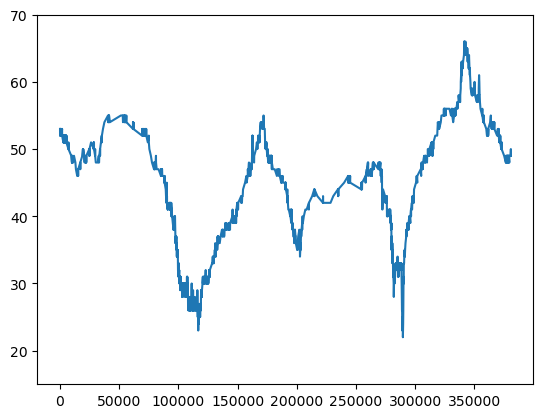

In [20]:
plt.plot(dht_df['timedelta'], dht_df['humidity'])
plt.ylim([15, 70])

(10.0, 35.0)

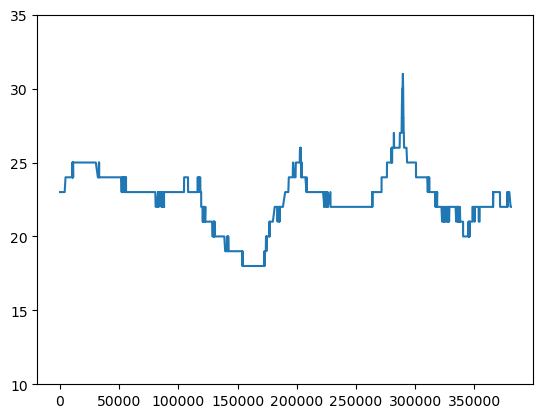

In [21]:
plt.plot(dht_df['timedelta'], dht_df['temperature'])
plt.ylim([10, 35])

/Users/frussen/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.0, 70.0)

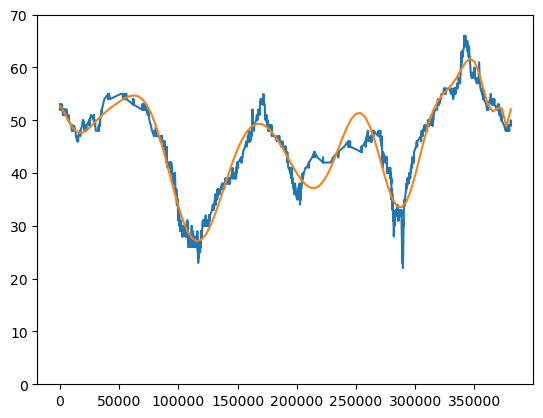

In [22]:
x = np.array(dht_df['timedelta'])
y = np.array(dht_df['humidity'])

hum_model = np.poly1d(np.polyfit(x, y, 27))
myline = np.linspace(1, 380818, 100)

plt.plot(x, y)
plt.plot(myline, hum_model(myline))
plt.ylim([0, 70])

(10.0, 35.0)

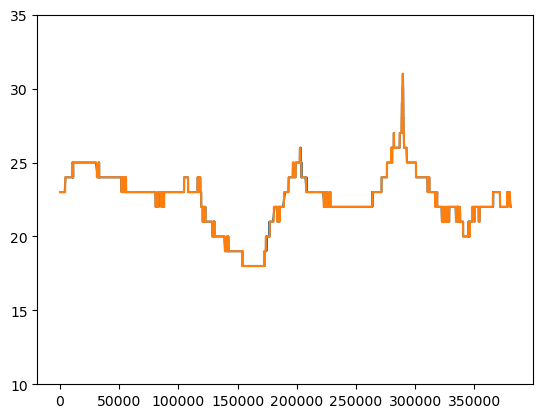

In [23]:
x = np.array(dht_df['timedelta'])
y = np.array(dht_df['temperature'])

temp_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
temp_model.fit(x.reshape(-1, 1),y)

x_test = []
for i in range(0,380800,100):
    x_test.append(i)
y_pred = temp_model.predict(np.array(x_test).reshape(-1, 1))

plt.plot(x, y)
plt.plot(x_test, y_pred)
plt.ylim([10, 35])

(0.0, 70.0)

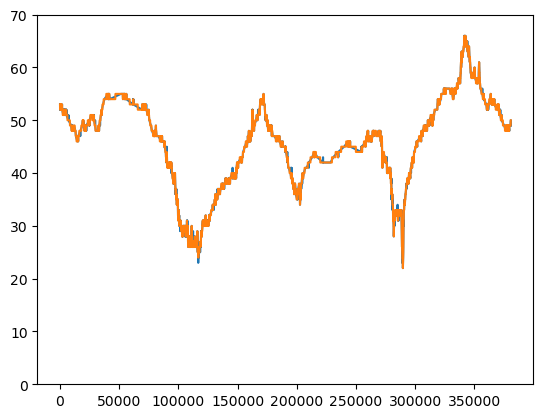

In [24]:
x = np.array(dht_df['timedelta'])
y = np.array(dht_df['humidity'])

hum_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
hum_model.fit(x.reshape(-1, 1),y)

x_test = []
for i in range(0,380800,100):
    x_test.append(i)
y_pred = hum_model.predict(np.array(x_test).reshape(-1, 1))

plt.plot(x, y)
plt.plot(x_test, y_pred)
plt.ylim([0, 70])

In [221]:
int(hum_model.predict(np.array([123]).reshape(-1, 1)))

53

In [33]:
 def publish_batch(client, n, size, interval):
    
    while n:
        c_size = size
        while(c_size):
            global counter
            if counter and n:
                pred = int(temp_model.predict(np.array([(tot_n - counter)*(380800/tot_n)]).reshape(-1, 1)))
                msg = '{"msg": "%d"}' % pred
                result = client.publish('dht_temp', msg)
                status = result[0]
                if status == 0:
                    print(f"Send `{msg}` to topic `dht_temp`")
                else:
                    print(f"Failed to send message to topic dht_temp")

                pred = int(hum_model.predict(np.array([(tot_n - counter)*(380800/tot_n)]).reshape(-1, 1)))
                msg = '{"msg": "%d"}' % pred
                result = client.publish('dht_hum', msg)
                if status == 0:
                    print(f"Send `{msg}` to topic `dht_hum`")
                else:
                    print(f"Failed to send message to topic dht_hum")

                counter -= 1
                n -= 1
            else:
                if n:
                    return print("\nAll data already sent!")
                else:
                    return print("\nProcess finished")
            
            c_size -= 1
        time.sleep(interval)
    print("\nProcess finished")


In [38]:
client = connect_mqtt()

In [39]:
tot_n = 1000
counter = tot_n

In [40]:
publish_batch(client, 1000, 1, 0.2)

Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "53"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "53"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "53"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "52"}` to topic `dht_hum`
Send `{"msg": "24"}` to topi

Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "55"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "55"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "55"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "55"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "55"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "54"}` to topic `dht_hum`
Send `{"msg": "24"}` to topi

Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "23"}` to topi

Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "25"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "24"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "26"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "25"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "26"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "27"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "27"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "29"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "28"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "29"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "30"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "31"}` to topic `dht_hum`
Send `{"msg": "22"}` to topi

Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "46"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "46"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "46"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "47"}` to topic `dht_hum`
Send `{"msg": "18"}` to topic `dht_temp`
Send `{"msg": "48"}` to topic `dht_hum`
Send `{"msg": "18"}` to topi

Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "40"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "40"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "39"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "41"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "40"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "39"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "39"}` to topic `dht_hum`
Send `{"msg": "25"}` to topic `dht_temp`
Send `{"msg": "37"}` to topic `dht_hum`
Send `{"msg": "25"}` to topic `dht_temp`
Send `{"msg": "37"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "37"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "37"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "37"}` to topic `dht_hum`
Send `{"msg": "24"}` to topi

Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "22"}` to topi

Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "45"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "41"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "44"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "42"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "43"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "42"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "41"}` to topic `dht_hum`
Send `{"msg": "25"}` to topi

Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "24"}` to topic `dht_temp`
Send `{"msg": "49"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "49"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "51"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topic `dht_temp`
Send `{"msg": "50"}` to topic `dht_hum`
Send `{"msg": "23"}` to topi

Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "59"}` to topic `dht_hum`
Send `{"msg": "21"}` to topic `dht_temp`
Send `{"msg": "59"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "59"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "58"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "58"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "57"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "57"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "57"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "57"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "57"}` to topic `dht_hum`
Send `{"msg": "22"}` to topic `dht_temp`
Send `{"msg": "58"}` to topic `dht_hum`
Send `{"msg": "21"}` to topic `dht_temp`
Send `{"msg": "60"}` to topic `dht_hum`
Send `{"msg": "21"}` to topi